In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix
from ast import literal_eval
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Reading data

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
data = pd.read_csv('../data/raw/csv/01-12/DrDoS_NTP.csv')
data.columns = [x.strip() for x in data.columns]
data['timestamp'] = data['Timestamp'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f') + timedelta(hours=4))
data['lst_timestamp'] = data.apply(
    lambda x: x['timestamp'] + timedelta(microseconds=x['Flow Duration']), axis=1)
print(data.shape)
data.head()

/home/caiolmart/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(1217007, 90)


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label,timestamp,lst_timestamp
0,0,172.16.0.5-192.168.50.1-60675-80-6,172.16.0.5,60675,192.168.50.1,80,6,2018-12-01 09:17:11.183810,5220876,12,9,1928.0,4290.0,509.0,0.0,160.666667,237.878247,1073.0,0.0,476.666667,565.257242,1190.987873,4.022313,2.610438e+05,1.117421e+06,5004919.0,2.0,215957.0,1.963245e+04,5.779980e+04,192825.0,2.0,5220754.0,652594.25,1.759944e+06,5005096.0,3.0,0,0,0,0,400,304,2.298465,1.723849,0.0,1073.0,282.636364,424.028587,179800.242424,0,0,0,0,1,0,0,0,0.0,296.095238,160.666667,476.666667,400,0,0,0,0,0,0,12,1928,9,4290,65535,243,4,32,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,205.174.165.72/c.php,1,DrDoS_NTP,2018-12-01 13:17:11.183810,2018-12-01 13:17:16.404686
1,7,172.16.0.5-192.168.50.1-60676-80-6,172.16.0.5,60676,192.168.50.1,80,6,2018-12-01 09:17:11.205636,12644252,5,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.553611,2.107375e+06,5.161910e+06,12644080.0,1.0,12644252.0,3.161063e+06,6.322011e+06,12644080.0,1.0,1.0,1.00,0.000000e+00,1.0,1.0,0,0,0,0,176,80,0.395437,0.158175,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,176,0,0,0,0,0,0,5,0,2,0,65535,28960,0,32,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,DrDoS_NTP,2018-12-01 13:17:11.205636,2018-12-01 13:17:23.849888
2,12858,192.168.50.7-65.55.163.78-50458-443-6,65.55.163.78,443,192.168.50.7,50458,6,2018-12-01 09:17:12.634569,3,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,666666.666667,3.000000e+00,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,0,0,40,0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,0,-1,0,20,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,BENIGN,2018-12-01 13:17:12.634569,2018-12-01 13:17:12.634572
3,10191,192.168.50.7-65.55.163.78-50465-443-6,65.55.163.78,443,192.168.50.7,50465,6,2018-12-01 09:17:13.458370,3,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,666666.666667,3.000000e+00,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,0,0,40,0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,0,-1,0,20,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,BENIGN,2018-12-01 13:17:13.458370,2018-12-01 13:17:13.458373
4,239,192.168.50.253-224.0.0.5-0-0-0,192.168.50.253,0,224.0.0.5,0,0,2018-12-01 09:17:13.470913,114329232,52,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.454827,2.

In [4]:
data['attack'] = (data.Label == 'DrDoS_NTP') * 1

## Train/validation split

In [5]:
data.lst_timestamp.describe()

count                        1217007
unique                       1214353
top       2018-12-01 14:39:20.581317
freq                               2
first     2018-12-01 13:17:12.634572
last      2018-12-01 14:51:39.813446
Name: lst_timestamp, dtype: object

In [6]:
train_test_threshold = datetime(2018, 12, 1, 14, 40, 0)
data_train = data[data.lst_timestamp <= train_test_threshold]
data_valid = data[data.lst_timestamp > train_test_threshold]
print(data_train.shape)
print(data_valid.shape)

(567638, 91)
(649369, 91)


### Modelling decision

As there are so few rows with NA values I will drop them.

In [7]:
data_train.isna().any(axis=1).sum()

21

In [8]:
data_valid.isna().any(axis=1).sum()

10

In [9]:
data_train = data_train.dropna()
data_train.shape

(567617, 91)

In [10]:
data_valid = data_valid.dropna()
data_valid.shape

(649359, 91)

In [11]:
data_train = data_train.dropna()
data_train.shape

(567617, 91)

In [12]:
data_valid = data_valid.dropna()
data_valid.shape

(649359, 91)

In [13]:
X_train, y_train = data_train.iloc[:, 8:-6], data_train.attack
X_valid, y_valid = data_valid.iloc[:, 8:-6], data_valid.attack

In [14]:
X_train.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,5220876,12,9,1928.0,4290.0,509.0,0.0,160.666667,237.878247,1073.0,0.0,476.666667,565.257242,1190.987873,4.022313,2.610438e+05,1.117421e+06,5004919.0,2.0,215957.0,1.963245e+04,5.779980e+04,192825.0,2.0,5220754.0,652594.25,1.759944e+06,5005096.0,3.0,0,0,0,0,400,304,2.298465,1.723849,0.0,1073.0,282.636364,424.028587,179800.242424,0,0,0,0,1,0,0,0,0.0,296.095238,160.666667,476.666667,400,0,0,0,0,0,0,12,1928,9,4290,65535,243,4,32,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,12644252,5,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.553611,2.107375e+06,5.161910e+06,12644080.0,1.0,12644252.0,3.161063e+06,6.322011e+06,12644080.0,1.0,1.0,1.00,0.000000e+00,1.0,1.0,0,0,0,0,176,80,0.395437,0.158175,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,176,0,0,0,0,0,0,5,0,2,0,65535,28960,0,32,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,3,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,666666.666667,3.000000e+00,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,0,0,40,0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,0,-1,0,20,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,3,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,666666.666667,3.000000e+00,0.000000e+00,3.0,3.0,3.0,3.000000e+00,0.000000e+00,3.0,3.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,0,0,40,0,666666.666667,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,0,-1,0,20,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,114329232,52,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.454827,2.241750e+06,4.083247e+06,9950741.0,1.0,114329232.0,2.241750e+06,4.083247e+06,9950741.0,1.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,0,0,0,0,0.454827,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,52,0,0,0,-1,-1,0,0,7.416667,2.466441,15.0,6.0,9527428.0,248706.681286,9950741.0,9092248.0


In [15]:
y_train.head()

0    1
1    1
2    0
3    0
4    0
Name: attack, dtype: int64

### Modelling decision

As there are so few rows with infinite values I will drop them.

In [16]:
np.isinf(X_train).any(axis=1).sum()

3213

In [17]:
np.isinf(X_valid).any(axis=1).sum()

3802

In [18]:
data_train = data_train[~np.isinf(X_train).any(axis=1)]
data_valid = data_valid[~np.isinf(X_valid).any(axis=1)]
print(data_train.shape)
print(data_valid.shape)

(564404, 91)
(645557, 91)


In [19]:
X_train, y_train = data_train.iloc[:, 8:-6], data_train.attack
X_valid, y_valid = data_valid.iloc[:, 8:-6], data_valid.attack

## Training

A simple decision tree with max depth 3.

In [20]:
clf = DecisionTreeClassifier(max_depth=3)

In [21]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

## Performance metrics

### ROC AUC

In [22]:
y_train_pred = clf.predict_proba(X_train)[:, 1]
y_valid_pred = clf.predict_proba(X_valid)[:, 1]

In [23]:
auc_train = roc_auc_score(y_train, y_train_pred)
auc_valid = roc_auc_score(y_valid, y_valid_pred)
print(f'ROC AUC Score on train: {auc_train}')
print(f'ROC AUC Score on validation: {auc_valid}')

ROC AUC Score on train: 0.998844697958053
ROC AUC Score on validation: 0.9970328039347374


### Cohen Kappa

In [24]:
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)

In [25]:
ck_train = cohen_kappa_score(y_train, y_train_pred)
ck_valid = cohen_kappa_score(y_valid, y_valid_pred)
print(f'Cohen Kappa on train: {ck_train}')
print(f'Cohen Kappa on validation: {ck_valid}')

Cohen Kappa on train: 0.9356463141042712
Cohen Kappa on validation: 0.843499540007225


### Confusion Matrix

Text(0.5, 24.0, 'Predicted')

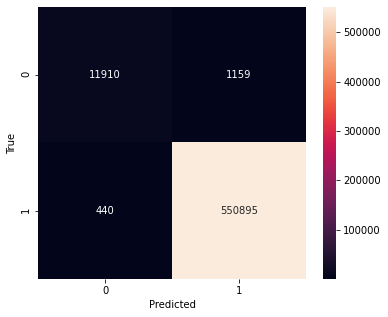

In [26]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='')
plt.ylabel('True')
plt.xlabel('Predicted')

Text(0.5, 24.0, 'Predicted')

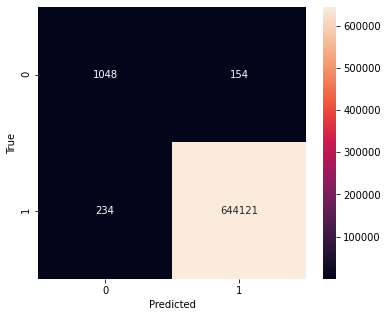

In [27]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_valid, y_valid_pred), annot=True, fmt='')
plt.ylabel('True')
plt.xlabel('Predicted')

## Ploting Tree

''

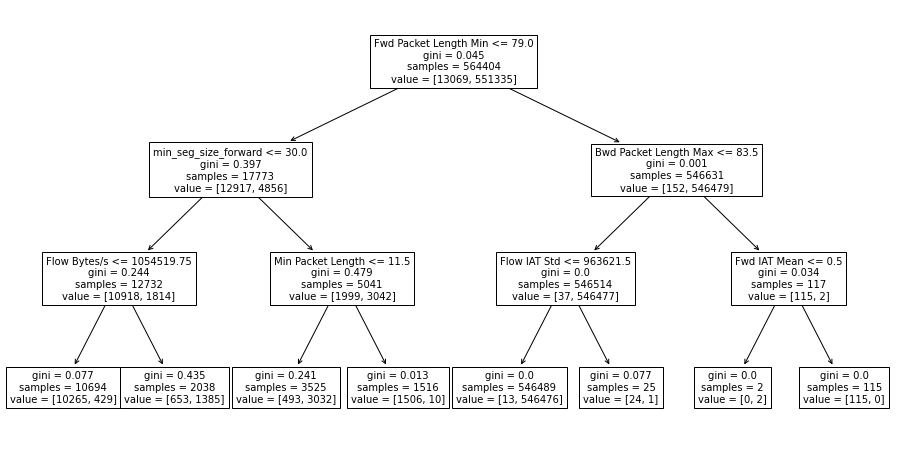

In [28]:
plt.figure(figsize=(16, 8))
plot_tree(clf, feature_names=X_train.columns, fontsize=10)
;